In [17]:
"""
CREATE FLEXIBILITY ENVELOPE DATASET
-----------------------------------
Compute and store flexibility envelopes for all buildings and climates over a specified
time window. For each (building_id, climate_id), the script:
  1. Runs the MPC optimization to obtain episode-wise UB/LB power bounds
  2. Extracts daily UB/LB arrays using extract_daily_building_bounds()
  3. Computes and saves flexibility envelopes + heatmaps

Author: Edouard Paupe
Date: 2025-10-20
"""

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.env import Env
from src.agents import RB, MPC
from src.flex import (envelope_for_zone_day,
                      plot_energy_bounds_from_file)


In [18]:
# =====================================================
# CONFIGURATION
# =====================================================

BASE_DIR = "/Users/edouardpaupe/Desktop/magnify-main_DATABASE"
POWER_BOUNDS_DIR = os.path.join(BASE_DIR, "data/power_bounds/")
FLEX_ENV_DIR = os.path.join(BASE_DIR, "data/flex_env/")
FLEX_IMG_DIR = os.path.join(BASE_DIR, "data/flex_env_images/")

START_TIME = datetime.datetime(2020, 1, 2, 0, 0, 0)
END_TIME   = datetime.datetime(2020, 1, 3, 0, 0, 0)
HISTORY_HOURS = 8
HORIZON_HOURS = 24
STEPS_PER_HOUR = 4
HP_POWER = 1  # [kW]
CLIMATE_IDS = [0] #range(6)  # 0–5

# Building archetypes 
BUILDING_IDS = [ "ep_SFH_age_0_climate_0_649"
]
#     ""ep_SFH_age_0_climate_0_1241", "ep_SFH_age_0_climate_0_821", "ep_SFH_age_0_climate_0_1241",
#     "ep_SFH_age_0_climate_1_259", "ep_SFH_age_0_climate_1_493", "ep_SFH_age_0_climate_1_535",
#     "ep_SFH_age_0_climate_2_1325", "ep_SFH_age_0_climate_2_1691", "ep_SFH_age_0_climate_2_1972",
#     "ep_SFH_age_0_climate_3_955", "ep_SFH_age_0_climate_3_1081", "ep_SFH_age_0_climate_3_1123",
#     "ep_SFH_age_0_climate_4_1072", "ep_SFH_age_0_climate_4_1688", "ep_SFH_age_0_climate_4_1709",
#     "ep_SFH_age_0_climate_5_417", "ep_SFH_age_0_climate_5_758", "ep_SFH_age_0_climate_5_928",
#     "ep_SFH_age_1_climate_0_42", "ep_SFH_age_1_climate_0_168", "ep_SFH_age_1_climate_0_249",
#     "ep_SFH_age_1_climate_1_32", "ep_SFH_age_1_climate_1_429", "ep_SFH_age_1_climate_1_458",
#     "ep_SFH_age_1_climate_2_762", "ep_SFH_age_1_climate_2_852", "ep_SFH_age_1_climate_2_1161",
#     "ep_SFH_age_1_climate_3_260", "ep_SFH_age_1_climate_3_451", "ep_SFH_age_1_climate_3_597"
# ]

In [ ]:
# FUNCTIONS DEFINITIONS: 

# =====================================================
# STEP 1 — OPTIMIZATION: Run MPC and retrieve UB/LB arrays
# =====================================================

def compute_episode_power_bounds(env, hp_power=HP_POWER):
    """
    Runs upper/lower MPC to compute (n_episodes, n_horizon) UB/LB arrays, aggregated across all zones.
    """
    controller = RB(n_zones=env.n_zones, T_min=20.0, T_max=22.0)

    upper_bound = MPC(
        armax_config=env.armax_config, target_temperature=21.0,
        T_min=np.full((env.horizon_length + 1, env.n_zones), 20),
        T_max=np.full((env.horizon_length + 1, env.n_zones), 22),
        history_length=env.history_length, horizon_length=env.horizon_length,
        objective="upper_bound"
    )

    lower_bound = MPC(
        armax_config=env.armax_config, target_temperature=21.0,
        T_min=np.full((env.horizon_length + 1, env.n_zones), 20),
        T_max=np.full((env.horizon_length + 1, env.n_zones), 22),
        history_length=env.history_length, horizon_length=env.horizon_length,
        objective="lower_bound"
    )

    obs, _ = env.reset()
    while not env.terminated:
        upper_bound.predict(obs)
        lower_bound.predict(obs)
        upper_bound.save_episode()
        lower_bound.save_episode()

        actions = controller.predict(obs)
        obs, _, _, _, _ = env.step(actions)

    # After optimization loop, collect results
    n_episodes = len(upper_bound.results["control_action"])
    horizon_length = env.horizon_length
    upper_power_bound_zone_avg = np.zeros((n_episodes, horizon_length))
    lower_power_bound_zone_avg = np.zeros((n_episodes, horizon_length))
    T0 = np.zeros((n_episodes, env.n_zones)) # Initial temperatures array initialization

    for t in range(n_episodes):
        u_upp = np.array([list(x.values()) for x in upper_bound.results["control_action"][t].values()])
        u_low = np.array([list(x.values()) for x in lower_bound.results["control_action"][t].values()])
        _T0 = np.array(list(lower_bound.results["temperature"][t][0].values()))

        u_upp = u_upp[env.history_length:, :]
        u_low = u_low[env.history_length:, :]

        u_upp_mean = np.mean(u_upp, axis=1)
        u_low_mean = np.mean(u_low, axis=1)

        #u_upp_mean = u_upp[:, 1]  # just selecting Zone 1
        #u_low_mean = u_low[:, 1]  # just selecting Zone 1

        upper_power_bound_zone_avg[t, :] = u_upp_mean * hp_power
        lower_power_bound_zone_avg[t, :] = u_low_mean * hp_power

        T0[t,:] = _T0 

    print("Upper power bound shape:", upper_power_bound_zone_avg.shape)
    print("Lower power bound shape:", lower_power_bound_zone_avg.shape)
    print("Initial temperatures shape:", T0.shape)

    return upper_power_bound_zone_avg, lower_power_bound_zone_avg, T0

# =====================================================
# STEP 2 — Extract daily bounds: separates the optimization results into daily (96,96) chunks
# =====================================================

def extract_daily_building_bounds(upper_power_bound, lower_power_bound, env, save_dir=None):
    """
    Extract daily UB/LB arrays (96 x horizon_length) for each day, aggregated across all zones.
    """
    n_episodes, n_horizon = upper_power_bound.shape
    block_size = 96  # 1 day = 96 episodes of 15 min
    n_blocks = n_episodes // block_size

    daily_bounds = {}
    building_num = int(env.building_id.split('_')[-1])
    climate_id = env.climate_id

    for b in range(n_blocks):
        start_idx = b * block_size
        end_idx = start_idx + block_size

        ub_chunk = upper_power_bound[start_idx:end_idx, :]
        lb_chunk = lower_power_bound[start_idx:end_idx, :]

        current_date = (env.start_time + datetime.timedelta(days=b)).date()
        day = current_date.day
        month = current_date.month
        year = current_date.year

        ub_name = f"build{building_num}_clim{climate_id}_{day:02d}_{month:02d}_{year}_UB"
        lb_name = f"build{building_num}_clim{climate_id}_{day:02d}_{month:02d}_{year}_LB"

        daily_bounds[ub_name] = ub_chunk
        daily_bounds[lb_name] = lb_chunk

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            ub_file_path = os.path.join(save_dir, f"{ub_name}.npy")
            lb_file_path = os.path.join(save_dir, f"{lb_name}.npy")
            
            # Check if files already exist
            if not os.path.exists(ub_file_path):
                np.save(ub_file_path, ub_chunk)
            else:
                print(f"File already exists, skipping: {ub_file_path}")

            if not os.path.exists(lb_file_path):
                np.save(lb_file_path, lb_chunk)
            else:
                print(f"File already exists, skipping: {lb_file_path}")

    print(f"Extracted {n_blocks} daily UB/LB pairs for building {building_num}, climate {climate_id}")
    return daily_bounds

# =====================================================
# STEP 3 — Compute and save flexibility envelopes
# =====================================================

def save_flexibility_envelopes(bounds_dict, flex_env_dir, flex_img_dir):
    os.makedirs(flex_env_dir, exist_ok=True)
    os.makedirs(flex_img_dir, exist_ok=True)

    for ub_name, ub_chunk in bounds_dict.items():
        if not ub_name.endswith("_UB"):
            continue
        base_name = ub_name.replace("_UB", "")
        lb_chunk = bounds_dict.get(f"{base_name}_LB")
        if lb_chunk is None:
            continue

        P_grid, durations = envelope_for_zone_day(ub_chunk, lb_chunk, dt_h=1/4, P_min=-0.01, P_max=1.0, dP=0.03)
        print(P_grid.shape)

        # Save CSV
        csv_path = os.path.join(flex_env_dir, f"{base_name}.csv")
        df = pd.DataFrame(
            durations,
            index=np.round(P_grid, 2),
            columns=[f"LeadTime_{i}" for i in range(durations.shape[1])]
        )
        df.index.name = "Power Level [kW]"
        df.to_csv(csv_path)

        # Save heatmap
        fig, ax = plt.subplots(figsize=(8, 5))
        im = ax.imshow(
            durations, aspect="auto", origin="lower",
            extent=[0, durations.shape[1]*0.25, P_grid[0], P_grid[-1]],
            cmap="viridis", vmin=0, vmax=24
        )
        plt.colorbar(im, ax=ax, label="Max sustained duration [h]")
        ax.set_xlabel("Lead time [h]")
        ax.set_ylabel("Power [kW]")
        ax.set_title(f"Flexibility Envelope — {base_name}")
        plt.tight_layout()
        plt.savefig(os.path.join(flex_img_dir, f"{base_name}.png"), dpi=300)
        #plt.close(fig)


In [20]:
#Main loop, just for one building and one climate ID for testing
for building_id in BUILDING_IDS:
        for climate_id in CLIMATE_IDS:
            print(f"\n>>> Processing {building_id} | Climate {climate_id}")

            env = Env(
                building_id=building_id,
                climate_id=climate_id,
                start_time=START_TIME,
                end_time=END_TIME,
                history_hours=HISTORY_HOURS,
                horizon_hours=HORIZON_HOURS,
                steps_per_hour=STEPS_PER_HOUR,
            )

            # 1 Compute (n_episodes, n_horizon) UB/LB
            ub, lb, T0 = compute_episode_power_bounds(env)
            



>>> Processing ep_SFH_age_0_climate_0_649 | Climate 0
Upper power bound shape: (96, 96)
Lower power bound shape: (96, 96)
Initial temperatures shape: (96, 10)


In [21]:
# Plot energy bounds for a given building , climate , date, episode 
try:
    fig, ax = plot_energy_bounds_from_file(
        building_num=1241,
        climate_id=0,
        day=2,
        month=1,
        year=2020,
        ep_idx=20,
        power_bounds_dir=POWER_BOUNDS_DIR,
        steps_per_hour=STEPS_PER_HOUR
    )
    plt.show()
except (FileNotFoundError, ValueError, IndexError) as e:
    print(f"Error: {e}")

Error: Upper bound file not found: /Users/edouardpaupe/Desktop/magnify-main_DATABASE/data/power_bounds/build1241_clim0_02_01_2020_UB.npy


In [22]:
print(T0.shape)
print(T0) 

(96, 10)
[[21.         21.         21.         21.         21.         21.
  21.         21.         21.         21.        ]
 [21.12081177 21.03572253 21.20981457 21.09604132 20.99841815 21.03729326
  21.09098159 21.09970273 21.09857582 21.01371846]
 [21.23214168 21.06628943 21.39773426 21.18432797 21.00826224 21.14117831
  21.2249567  21.32351663 21.20248911 21.0694394 ]
 [21.33107966 21.09064236 21.5615435  21.2644313  21.02573902 21.24120467
  21.34990933 21.5266044  21.30143953 21.12390761]
 [21.41851322 21.1102376  21.70374631 21.33731014 21.04859467 21.33712534
  21.4663544  21.71084799 21.39557633 21.17713118]
 [21.49542985 21.12609278 21.82659743 21.40369132 21.07502242 21.428692
  21.57474713 21.88037145 21.48504244 21.22911871]
 [21.56400504 21.14180115 21.93357127 21.46478545 21.10446375 21.51716322
  21.6757616  22.03552983 21.57049493 21.28019389]
 [21.62697091 21.15760552 22.02877783 21.52189852 21.13581834 21.60239594
  21.77105961 21.87662529 21.65246654 21.33044533]
 

In [23]:
bounds_dict = extract_daily_building_bounds(ub, lb, env, save_dir=POWER_BOUNDS_DIR)

Extracted 1 daily UB/LB pairs for building 649, climate 0


(34,)


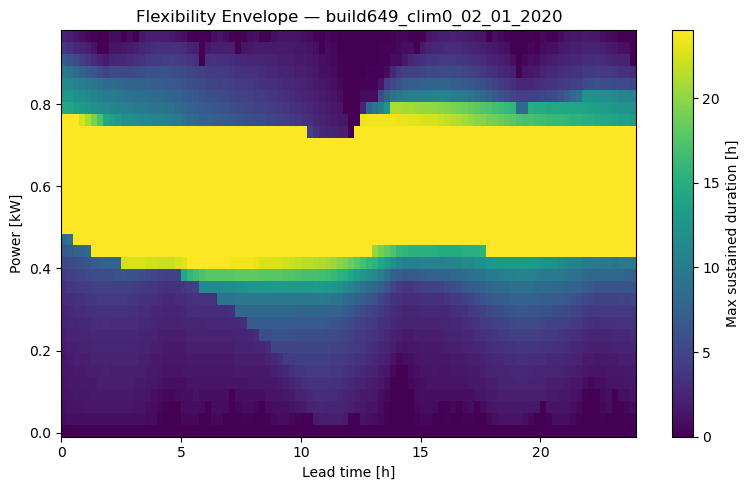

In [24]:
# 3 Compute and save flexibility envelopes
save_flexibility_envelopes(bounds_dict, FLEX_ENV_DIR, FLEX_IMG_DIR)